In [1]:
%%capture
! apt install -y python-opengl ffmpeg > /dev/null 2>&1
! pip install pyvirtualdisplay highway-env stable_baselines3 pygame pyvirtualdisplay

In [1]:
import gym
import highway_env
import pygame
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns
import time
from tqdm import tqdm
import IPython.display as ipythondisplay
from pyvirtualdisplay import Display
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
import torch.nn.functional as F
from copy import deepcopy
import random
import scipy.stats

In [2]:
def create_anim(frames, dpi, fps):
    plt.figure(figsize=(frames[0].shape[1] / dpi, frames[0].shape[0] / dpi), dpi=dpi)
    patch = plt.imshow(frames[0])
    def setup():
        plt.axis('off')
    def animate(i):
        patch.set_data(frames[i])
    anim = animation.FuncAnimation(plt.gcf(), animate, init_func=setup, frames=len(frames), interval=fps)
    return anim

def test_and_save(env, models, filename, dpi, fps, repeats=1, change_observation_to_GS=False):
    display = Display(visible=0, size=(1024, 768))
    display.start()
    env = gym.make(env)
    if change_observation_to_GS:
        env.configure({"observation": {
                    "type": "GrayscaleObservation",
                    "observation_shape": (128, 64),
                    "stack_size": 1,
                    "weights": [0.2989, 0.5870, 0.1140],  # weights for RGB conversion
                    "scaling": 1.75,
                }})
        transform = transforms.Compose([transforms.ToPILImage(),
                                        transforms.ToTensor()])
    frames = []
    for r in range(repeats):
        rewards = 0
        state, _ = env.reset()
        done = False
        for step in range(100):
            Qs = np.zeros((50, env.action_space.n))
            for i, model in enumerate(models[-50:]):
                if change_observation_to_GS:
                    state = transform(torch.tensor(state).squeeze()).unsqueeze(0)
                Qs[i] = model(torch.tensor(state)).detach().numpy()
            action = np.argmax(np.mean(Qs, axis=0))
            frames.append(env.render(mode='rgb_array'))
            if done:
                print(f'Reward: {rewards}\nSteps: {step}')
                break
            state, reward, done, info, _ = env.step(action)
            rewards += reward

    env.close()
    anim = create_anim(frames, dpi, fps)
    anim.save(filename)
    return anim

In [3]:
def plots_func(datas, labels, repeats, episodes, sliding_win, CI, title='Rewards', window_size=50, CL=0.95):
    fig, ax = plt.subplots(figsize=(20,12))
    for idx, data in enumerate(datas):
        df = pd.DataFrame(data.copy())
        if len(data) == 1:
            if sliding_win:
                plot_data = df.iloc[0,:].rolling(window=window_size, min_periods=1, center=True).mean().copy()
            else:
                plot_data = df.copy()
            plt.plot(plot_data, label=labels[idx])
        else:
            if sliding_win:
                for row in range(repeats):
                    df.iloc[row,:] = df.iloc[row,:].rolling(window=window_size, min_periods=1, center=True).mean().copy()
                plot_data = np.mean(df, axis=0)
            else:
                plot_data = np.mean(df, axis=0)

            plt.plot(plot_data, label=labels[idx])
            if CI:
                data_mean, data_std = np.mean(df, axis=0), np.std(df, axis=0)
                tscore  = np.abs(scipy.stats.t.ppf(q=(1+CL)/2, df=repeats-1))
                ci_up   = data_mean + tscore*data_std/np.sqrt(repeats)
                ci_down = data_mean - tscore*data_std/np.sqrt(repeats)
                plt.fill_between(range(episodes), ci_up, ci_down, alpha=0.3)
            
    plt.title(f'{title} Plot', fontsize=20)
    plt.xlabel('Episode')
    plt.ylabel(f'Total {title} per Episode')
    plt.grid()
    plt.legend(fontsize=15)
    sns.despine()


In [4]:
def repeat(repeats, episodes):
    rewards = np.zeros((repeats, episodes))
    losses  = np.zeros((repeats, episodes))
    models = []
    show_output_plots = False
    if repeats == 1:
        show_output_plots = True
    start = time.time()
    for rep in range(repeats):
        ipythondisplay.clear_output(wait=True)
        print("REPEAT {}/{} :".format(rep+1, repeats))
        
        agent = DQN_agent(env, gamma, max_bufferSize, lr, epsilon_max, epsilon_min, epsilon_decay_rate,
                          network, change_highspeed_reward, 
                          change_observation_to_GS, pre_trained_model)
        rewards[rep], losses[rep], _, model = agent.train(episodes, max_steps, batch_size, show_output_plots)
        models.append(model)
        
    print(f'Elapsed Time: In average {(time.time() - start)/repeats:.3f}s for each repeat')
    return(rewards, losses, models)

In [5]:
class DQN_agent():
    def __init__(self, env, gamma, max_bufferSize, lr, epsilon_max, epsilon_min, epsilon_decay_rate, network, change_highspeed_reward, change_observation_to_GS, pre_trained_model=False):
        self.env = gym.make(env)
        if change_highspeed_reward != False:
            self.env.configure({'high_speed_reward':change_highspeed_reward})
        self.change_observation_to_GS = change_observation_to_GS
        if change_observation_to_GS:
            self.env.configure({"observation": {
                                    "type": "GrayscaleObservation",
                                    "observation_shape": (128, 64),
                                    "stack_size": 1,
                                    "weights": [0.2989, 0.5870, 0.1140],  # weights for RGB conversion
                                    "scaling": 1.75,
                                }})
        self.transform = transforms.Compose([transforms.ToPILImage(),
                                             transforms.ToTensor()])
        self.gamma = gamma
        self.actions_size = self.env.action_space.n
        self.state_size = self.env.reset()[0].size
        self.epsilon = epsilon_max
        self.epsilon_max = epsilon_max
        self.epsilon_min = epsilon_min
        self.epsilon_decay_rate = epsilon_decay_rate
        self.exp_buffer = []
        self.max_bufferSize = max_bufferSize

        # network model :
        if pre_trained_model == False:
            self.model = network(number_of_states=self.state_size, number_of_actions=self.actions_size)
        else:
            self.model = pre_trained_model
        self.lossfunc = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)


    def choose_action(self, state):
        p = np.random.random()
        if p < self.epsilon:
            self.action = self.env.action_space.sample()
        else:
            with torch.no_grad():
                state = torch.tensor(state).unsqueeze(0)
                self.action = np.argmax(self.model(state).detach().numpy())


    def save_buffer(self, experience):
        self.exp_buffer.append(experience)
        if len(self.exp_buffer) > self.max_bufferSize:
            self.exp_buffer.pop(0)


    def update_model(self, sample_batch):
        # compute target :
        not_done_index = [idx for idx, exp in enumerate(sample_batch) if not exp[4]]
        y_target = torch.tensor([exp[2] for exp in sample_batch], dtype=torch.float32)
        with torch.no_grad():
            y_target[not_done_index] += self.gamma * np.max(self.model(torch.tensor(np.array([np.array(exp[3]) for exp in sample_batch if not exp[4]], dtype=np.float32))).detach().numpy(), axis=1)

        # train
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model.to(device)
        self.model.train()
        X = torch.tensor(np.array([np.array(exp[0]) for exp in sample_batch]), dtype=torch.float32)
        
        x, y = X.to(device), y_target.to(device).reshape(-1,1)
        # forward
        batch_actions = torch.tensor(np.array([exp[1] for exp in sample_batch])).to(device).reshape(-1,1)
        output = self.model(x).gather(1, batch_actions)
        trloss = self.lossfunc(output, y)
        
        # set the parameter gradients to zero
        self.optimizer.zero_grad()

        # backward
        trloss.backward()
        self.optimizer.step()
            
        self.model.to('cpu')
        return trloss


    def epsilon_decay(self, episode):
        self.epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min)*np.exp(-self.epsilon_decay_rate*episode)


    def output_plot(self, reward, loss):
        ipythondisplay.clear_output(wait=True)
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
        ax1.set_xlabel('Episode')
        ax1.set_ylabel('Loss')
        ax1.plot(loss)
        ax2.set_xlabel('Episode')
        ax2.set_ylabel('Reward')
        ax2.plot(reward)
        plt.suptitle('Training...')
        plt.pause(0.001)


    def train(self, episodes, max_steps, batch_size, show_output_plots=True):
        rewards = []
        losses = []
        steps = []
        models = []
        with tqdm(range(episodes)) as train:
            for ep in train:

                state, _ = self.env.reset()
                if self.change_observation_to_GS:
                    state = self.transform(torch.tensor(state))
                rwrd = 0
                lose = 0
                counter = 0
                for step in range(max_steps):
                    self.choose_action(state)

                    next_state, reward, done, _, _ = self.env.step(self.action)
                    if self.change_observation_to_GS:
                        next_state = self.transform(torch.tensor(next_state))
                    rwrd += reward

                    self.save_buffer([state, self.action, reward, next_state, done])
                    if len(self.exp_buffer) >= batch_size:
                        sample_batch = random.sample(self.exp_buffer, batch_size)

                        batch_loss = self.update_model(sample_batch)

                        counter += 1
                        lose += (batch_loss.item() - lose)/counter

                    train.set_postfix(reward=rwrd, step=step, lose=lose, epsilon=self.epsilon, refresh=True)
                    state = next_state
                    if done:
                        break

                steps.append(step+1)
                rewards.append(rwrd)
                losses.append(lose)
                models.append(deepcopy(self.model))

                if (ep + 1) % 10 == 0 and show_output_plots:
                    self.output_plot(rewards, losses)
                    
                self.epsilon_decay(ep)

        return rewards, losses, steps, models

In [6]:
class fully_connected_structure(nn.Module):
# class Net_Structure:
    def __init__(self, number_of_states, number_of_actions):
        super(fully_connected_structure, self).__init__()
        self.number_of_states = number_of_states

        # definig layers
        self.fltn = nn.Flatten()
        self.fc1 = nn.Linear(in_features=number_of_states, out_features=128)
        self.fc2 = nn.Linear(in_features=128,              out_features=256)
        self.fc3 = nn.Linear(in_features=256,              out_features=128)
        self.fc4 = nn.Linear(in_features=128,              out_features=number_of_actions)

    def forward(self, x):

        # defining forward steps
        x = x.view(-1, self.number_of_states)
        x = F.relu(self.fc1(x), inplace=True)
        x = F.relu(self.fc2(x), inplace=True)
        x = F.relu(self.fc3(x), inplace=True)
        x = self.fc4(x)

        return x

In [7]:
class convolutional_structure(nn.Module):
# class Net_Structure:
    def __init__(self, number_of_states, number_of_actions):
        super(convolutional_structure, self).__init__()

        # definig layers
        self.conv1 = nn.Conv2d(1,  16, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.fc1 = nn.Linear(2080, number_of_actions)

    def forward(self, x):
        
        x = F.relu(self.conv1(x), inplace=True)
        x = F.relu(self.conv2(x), inplace=True)
        x = F.relu(self.conv3(x), inplace=True)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc1(x)
        
        return x

---
---
# **Merge task**


## with Deep Q-learning and Fully-connected network

In [20]:
# parameters
env = 'merge-v0'
gamma = 0.9
lr = 5e-4
max_bufferSize = 10000
epsilon_max = 1
epsilon_min = 0.005
epsilon_decay_rate = 0.005
episodes = 2000
max_steps = 1000
batch_size = 32
repeats = 5
network = fully_connected_structure
change_highspeed_reward = False
change_observation_to_GS = False
pre_trained_model = False

In [21]:
rewards_merge_FC, losses_merge_FC, models_merge_FC = repeat(repeats, episodes)

REPEAT 5/5 :


100%|██████████| 2000/2000 [28:24<00:00,  1.17it/s, epsilon=0.00505, lose=0.0258, reward=14.1, step=15] 

Elapsed Time: In average 1699.133s for each repeat


/opt/conda/lib/python3.7/site-packages/gym/utils/passive_env_checker.py:32: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 5)
  "A Box observation space has an unconventional shape (neither an image, nor a 1D vector). "
/opt/conda/lib/python3.7/site-packages/gym/utils/passive_env_checker.py:290: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  "No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps."


Reward: 14.137985712632647
Steps: 16


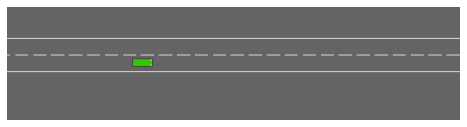

In [49]:
anim_merge_FC = test_and_save(env='merge-v0', models=[model[-1] for model in models_merge_FC], filename='test_merge_FC.mp4', dpi=72, fps=200)
ipythondisplay.HTML(anim_merge_FC.to_jshtml())

---
## with Deep Q-learning and Convolutional network

In [43]:
# parameters
env = 'merge-v0'
gamma = 0.9
lr = 5e-4
max_bufferSize = 10000
epsilon_max = 1
epsilon_min = 0.005
epsilon_decay_rate = 0.005
episodes = 2000
max_steps = 1000
batch_size = 32
repeats = 5
network = convolutional_structure
change_highspeed_reward = False
change_observation_to_GS = True
pre_trained_model = False

In [ ]:
rewards_merge_CV, losses_merge_CV, models_merge_CV = repeat(repeats, episodes)

REPEAT 3/5 :


 60%|██████    | 1200/2000 [14:27<11:05,  1.20it/s, epsilon=0.00748, lose=0.0272, reward=11.8, step=12]

/opt/conda/lib/python3.7/site-packages/gym/utils/passive_env_checker.py:32: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 5)
  "A Box observation space has an unconventional shape (neither an image, nor a 1D vector). "
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/gym/utils/

Reward: 13.471319045965979
Steps: 15


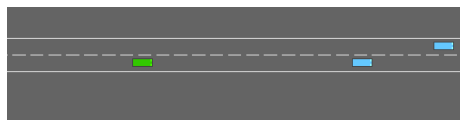

In [42]:
anim_merge_CV = test_and_save(env='merge-v0', models=[model[-1] for model in models_merge_CV], filename='test_merge_CV.mp4', dpi=72, fps=200, change_observation_to_GS=True)
ipythondisplay.HTML(anim_merge_CV.to_jshtml())

___
## with changed config (high-speed reward) 

In [18]:
# parameters
env = 'merge-v0'
gamma = 0.9
lr = 5e-4
max_bufferSize = 10000
epsilon_max = 1
epsilon_min = 0.005
epsilon_decay_rate = 0.005
episodes = 2000
max_steps = 1000
batch_size = 32
repeats = 1
network = fully_connected_structure
change_highspeed_reward = True
change_observation_to_GS = False
pre_trained_model = False

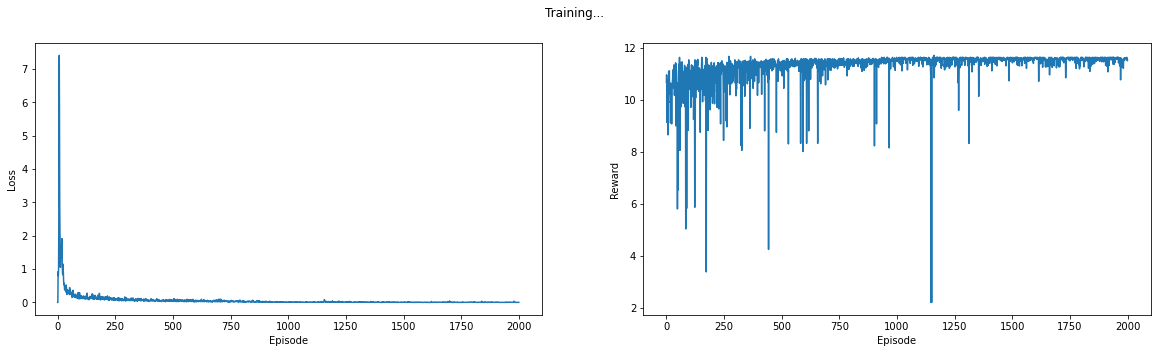

100%|██████████| 2000/2000 [23:48<00:00,  1.40it/s, epsilon=0.00505, lose=0.00258, reward=11.5, step=11]

Elapsed Time: In average 1428.103s for each repeat


In [19]:
rewards_merge_CR, losses_merge_CR, models_merge_CR = repeat(repeats, episodes)

/opt/conda/lib/python3.7/site-packages/gym/utils/passive_env_checker.py:32: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 5)
  "A Box observation space has an unconventional shape (neither an image, nor a 1D vector). "
/opt/conda/lib/python3.7/site-packages/gym/utils/passive_env_checker.py:290: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  "No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps."


Reward: 11.443541268188199
Steps: 12


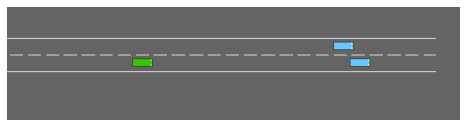

In [76]:
anim_merge_CR = test_and_save(env='merge-v0', models=[model[-1] for model in models_merge_CR], filename='test_merge_CR.mp4', dpi=72, fps=200)
ipythondisplay.HTML(anim_merge_CR.to_jshtml())

---
## Comparison

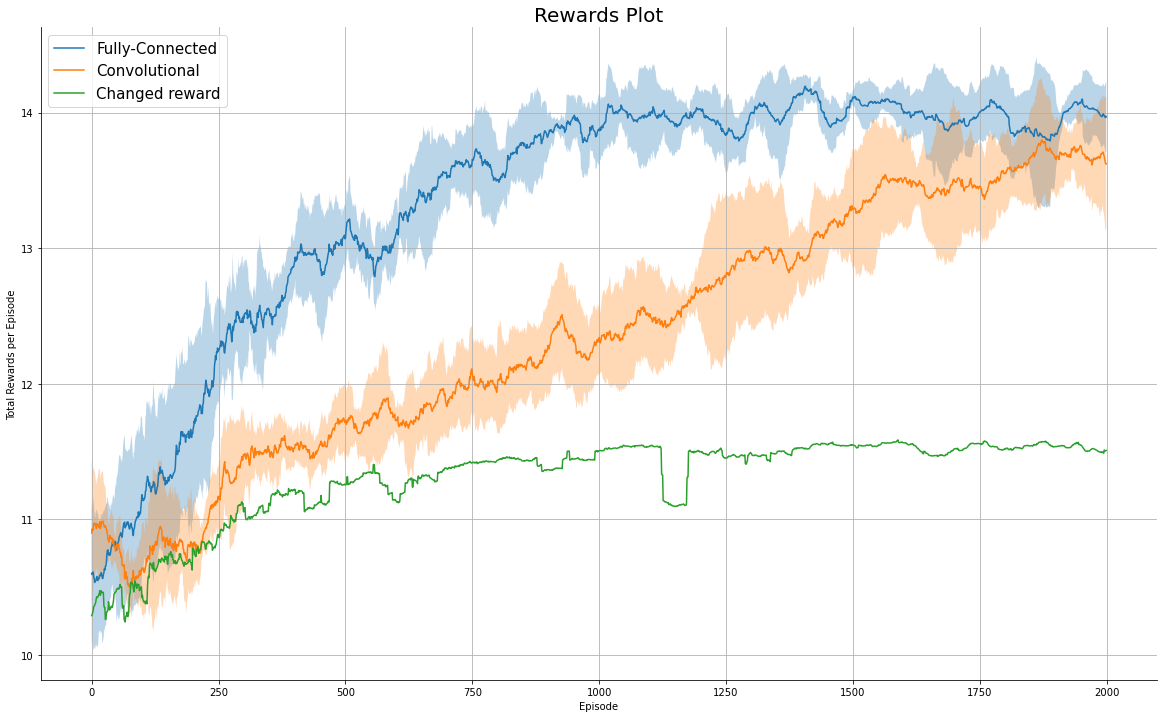

In [46]:
plots_func(datas=[rewards_merge_FC, rewards_merge_CV, rewards_merge_CR], labels=['Fully-Connected', 'Convolutional', 'Changed reward'], 
           repeats=5, episodes=2000, sliding_win=True, CI=True, title='Rewards', window_size=50, CL=0.95)

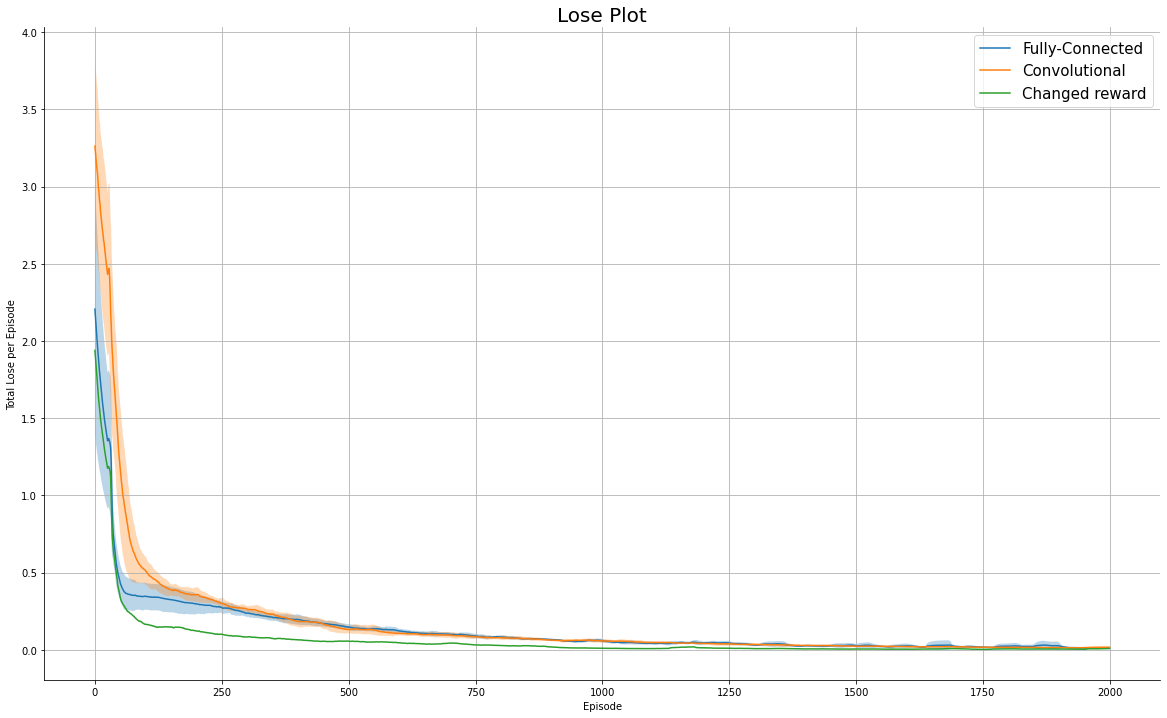

In [45]:
plots_func(datas=[losses_merge_FC, losses_merge_CV, losses_merge_CR], labels=['Fully-Connected', 'Convolutional', 'Changed reward'], 
           repeats=5, episodes=2000, sliding_win=True, CI=True, title='Lose', window_size=50, CL=0.95)

## T-test for rewards comparison

In [13]:
a = np.mean(rewards_merge_FC, axis = 0)
b = np.mean(rewards_merge_CV, axis = 0)
scipy.stats.ttest_ind(a, b)

Ttest_indResult(statistic=28.14941026389803, pvalue=3.2632640388392195e-159)

---
---
# **Highway-fast task**  

## with random weight initialization

In [24]:
# parameters
env = 'highway-fast-v0'
gamma = 0.9
lr = 5e-4
max_bufferSize = 10000
epsilon_max = 1
epsilon_min = 0.005
epsilon_decay_rate = 0.01
episodes = 1000
max_steps = 1000
batch_size = 32
repeats = 5
network = fully_connected_structure
change_highspeed_reward = False
change_observation_to_GS = False
pre_trained_model = False

In [25]:
rewards_highway_RW, losses_highway_RW, models_highway_RW = repeat(repeats, episodes)

REPEAT 5/5 :


100%|██████████| 1000/1000 [31:54<00:00,  1.91s/it, epsilon=0.00505, lose=1.07, reward=21.9, step=29] 

Elapsed Time: In average 1946.966s for each repeat


/opt/conda/lib/python3.7/site-packages/gym/utils/passive_env_checker.py:32: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 5)
  "A Box observation space has an unconventional shape (neither an image, nor a 1D vector). "
/opt/conda/lib/python3.7/site-packages/gym/utils/passive_env_checker.py:290: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  "No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps."


Reward: 21.886887835703007
Steps: 30
Reward: 23.81727859777578
Steps: 30
Reward: 22.553554502369117
Steps: 30
Reward: 22.719022611278515
Steps: 30
Reward: 21.152931009801165
Steps: 30


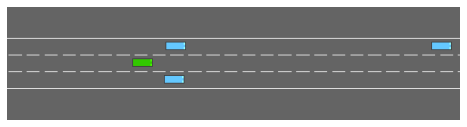

In [18]:
anim_highway_RW = test_and_save(env='highway-fast-v0', models=[model[-1] for model in models_highway_RW], filename='test_highway_RW.mp4', dpi=72, fps=120, repeats=5)
ipythondisplay.HTML(anim_highway_RW.to_jshtml())

---
## with transfer learning

In [9]:
# parameters
env = 'highway-fast-v0'
gamma = 0.9
lr = 5e-4
max_bufferSize = 10000
epsilon_max = 1
epsilon_min = 0.005
epsilon_decay_rate = 0.01
episodes = 1000
max_steps = 1000
batch_size = 32
repeats = 5
network = fully_connected_structure
change_highspeed_reward = False
change_observation_to_GS = False
pre_trained_model = torch.load('/kaggle/input/highway-trained-models2/0_model_4.pth')
# pre_trained_model = models_merge_FC[-1][-1]

In [10]:
rewards_highway_TW, losses_highway_TW, models_highway_TW = repeat(repeats, episodes)

REPEAT 5/5 :


100%|██████████| 1000/1000 [27:40<00:00,  1.66s/it, epsilon=0.00505, lose=1.29, reward=24, step=29]   


Elapsed Time: In average 1696.712s for each repeat


/opt/conda/lib/python3.7/site-packages/gym/utils/passive_env_checker.py:32: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 5)
  "A Box observation space has an unconventional shape (neither an image, nor a 1D vector). "
/opt/conda/lib/python3.7/site-packages/gym/utils/passive_env_checker.py:290: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  "No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps."


Reward: 24.75072919396905
Steps: 30
Reward: 25.659182256724037
Steps: 30
Reward: 28.04363179861295
Steps: 30
Reward: 26.499878997218538
Steps: 30
Reward: 27.830524626229117
Steps: 30


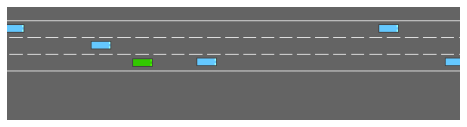

In [20]:
anim_highway_TW = test_and_save(env='highway-fast-v0', models=[model[-1] for model in models_highway_TW], filename='test_highway_TW.mp4', dpi=72, fps=120, repeats=5)
ipythondisplay.HTML(anim_highway_TW.to_jshtml())

---
## Comparison

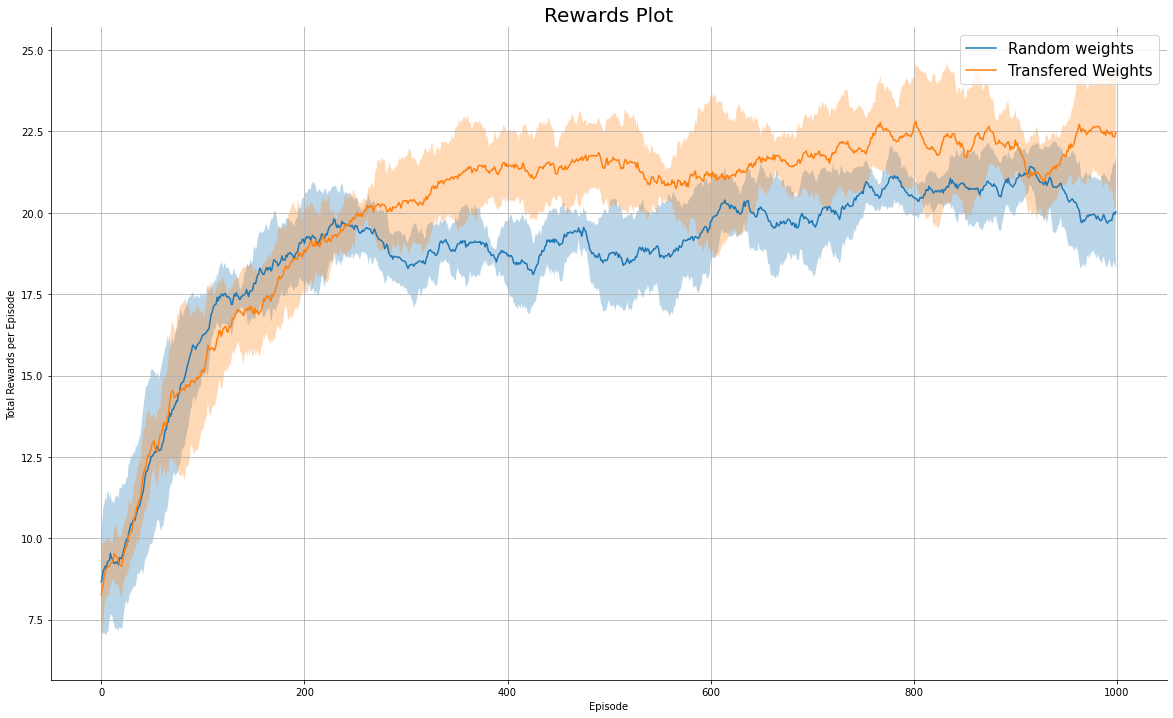

In [20]:
plots_func(datas=[rewards_highway_RW, rewards_highway_TW], labels=['Random weights', 'Transfered Weights'], 
           repeats=5, episodes=1000, sliding_win=True, CI=True, title='Rewards', window_size=50, CL=0.95)

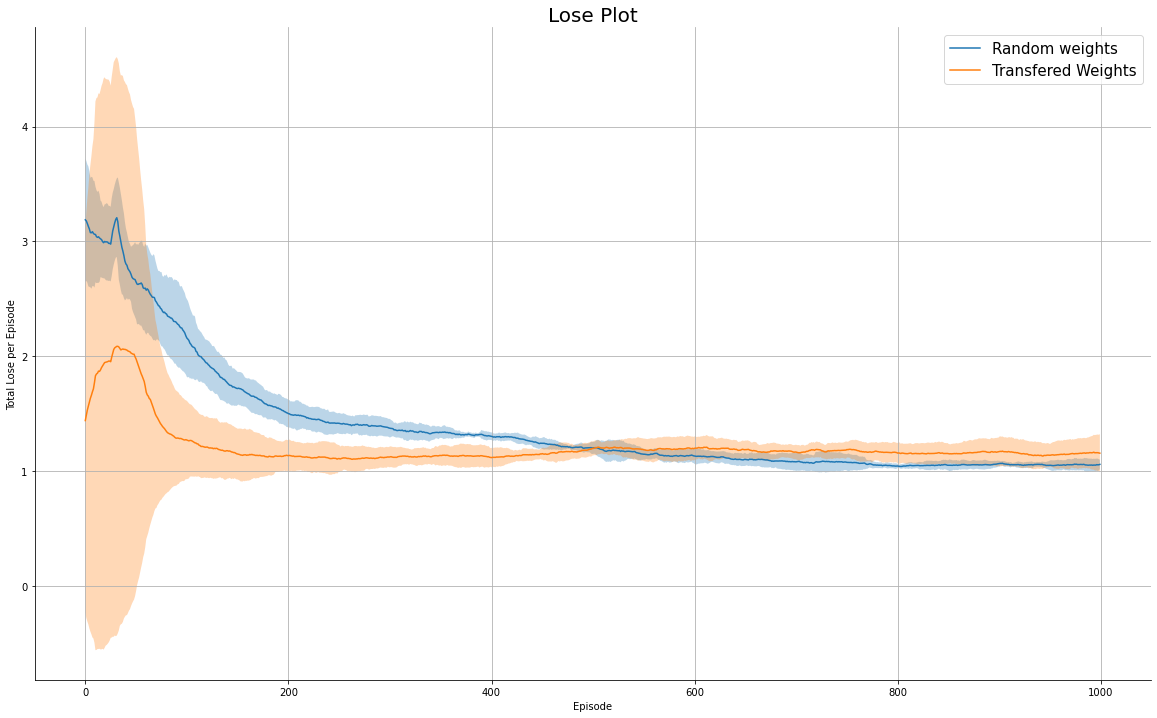

In [23]:
plots_func(datas=[losses_highway_RW, losses_highway_TW], labels=['Random weights', 'Transfered Weights'], 
           repeats=5, episodes=1000, sliding_win=True, CI=True, title='Lose', window_size=50, CL=0.95)